We follow a similar approach, which is written on paper - refer to D2W5 of notion.

In [17]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np

# Load data
u = md.Universe('md_1.tpr', 'md_1_noPBC.xtc')
u.trajectory[-1]
protein = u.select_atoms("protein")
backbone = protein.select_atoms("backbone")
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

t_eq = 15000 # ps
# Time Data
ti = u.trajectory[0].time
tf = u.trajectory[-1].time
nt = len(u.trajectory)-1
deltat = (tf-ti)/nt
t = np.linspace(ti,tf,nt+1)
mask = (t >= t_eq)

Compound mean:
$$
\langle x \rangle _n = \frac{\langle x \rangle _{n-1} (n-1) + x_n}{n} = \langle x \rangle _{n-1} + \frac{x_n - \langle x \rangle _{n-1}}{n} 
$$

In [18]:
def e2e_triple_mean_vec(mol, mask):
    chains = protein.fragments[3*mol:3*mol+3] # Pick Chains
    start_mean = [np.zeros(3) for _ in range(3)] # 3 start points ea chain
    end_mean   = [np.zeros(3) for _ in range(3)] # 3 end
    counts = [0, 0, 0] # counts for mean

    for ts in u.trajectory[mask]:
        for j, ch in enumerate(chains):
            chain_bkbn = ch.select_atoms("backbone")
            coords = chain_bkbn.positions / 10.0
            a = coords[0]
            b = coords[-1]
            if b[2] < a[2]: # Make sure we have small z first
                a, b = b, a
            counts[j] += 1
            start_mean[j] += (a - start_mean[j]) / counts[j]
            end_mean[j]   += (b - end_mean[j])   / counts[j]

    start_avg = np.mean(start_mean, axis=0)
    end_avg   = np.mean(end_mean,   axis=0)
    return start_avg, end_avg

def line_fun(start, end):
    x1, y1, z1 = start
    x2, y2, z2 = end
    # Slope
    mx = (x2 - x1)/(z2 - z1)
    my = (y2 - y1)/(z2 - z1)
    # Intercept
    bx = x1 - mx*z1
    by = y1 - my*z1

    x_z = lambda z: mx*z + bx
    y_z = lambda z: my*z + by

    return x_z, y_z

def line_par(start, end):
    x1, y1, z1 = start
    x2, y2, z2 = end
    # Slope
    mx = (x2 - x1)/(z2 - z1)
    my = (y2 - y1)/(z2 - z1)
    # Intercept
    bx = x1 - mx*z1
    by = y1 - my*z1

    return (mx,my), (bx,by)

Get the center of the fibril, and the representations of the collagen molecules: e2e vectors.

In [19]:
# Z values, important for evaluations
coords_tot = backbone.positions / 10.0
z_mx = max(coords_tot[:, 2])
z_mn = min(coords_tot[:, 2])
z_rep = (z_mx - z_mn)/2

In [20]:
# Center of Fibril
fib_coords = []
for ts in u.trajectory[mask]:
    coords = backbone.positions / 10
    fib_coords.append(coords)
fib_mean = np.mean(fib_coords, 0)
nm_slab = 2
top_slab = fib_mean[fib_mean[:, 2] >= max(fib_mean[:,2]) - nm_slab]
bottom_slab =  fib_mean[fib_mean[:, 2] <= min(fib_mean[:,2]) + nm_slab]
top_vec = np.array([np.mean(top_slab[:, 0]), np.mean(top_slab[:, 1]), max(fib_mean[:,2])])
low_vec = np.array([np.mean(bottom_slab[:, 0]), np.mean(bottom_slab[:, 1]), min(fib_mean[:,2])])
x_cf, y_cf = line_fun(low_vec, top_vec)

In [21]:
x_cfm, y_cfm = x_cf(z_rep), y_cf(z_rep) # Center of fibril representation

tot_mol = int((protein.fragindices[-1] + 1)/3)
radius = np.zeros(tot_mol)

for mol in range(tot_mol):
    st_v, ed_v = e2e_triple_mean_vec(mol, mask) # End to End
    x_mol, y_mol = line_fun(st_v, ed_v) # Functions
    x_mmol, y_mmol = x_mol(z_rep), y_mol(z_rep) # Points rep
    radius[mol] = ((x_mmol - x_cfm)**2 + (y_mmol - y_cfm)**2)**(1/2)

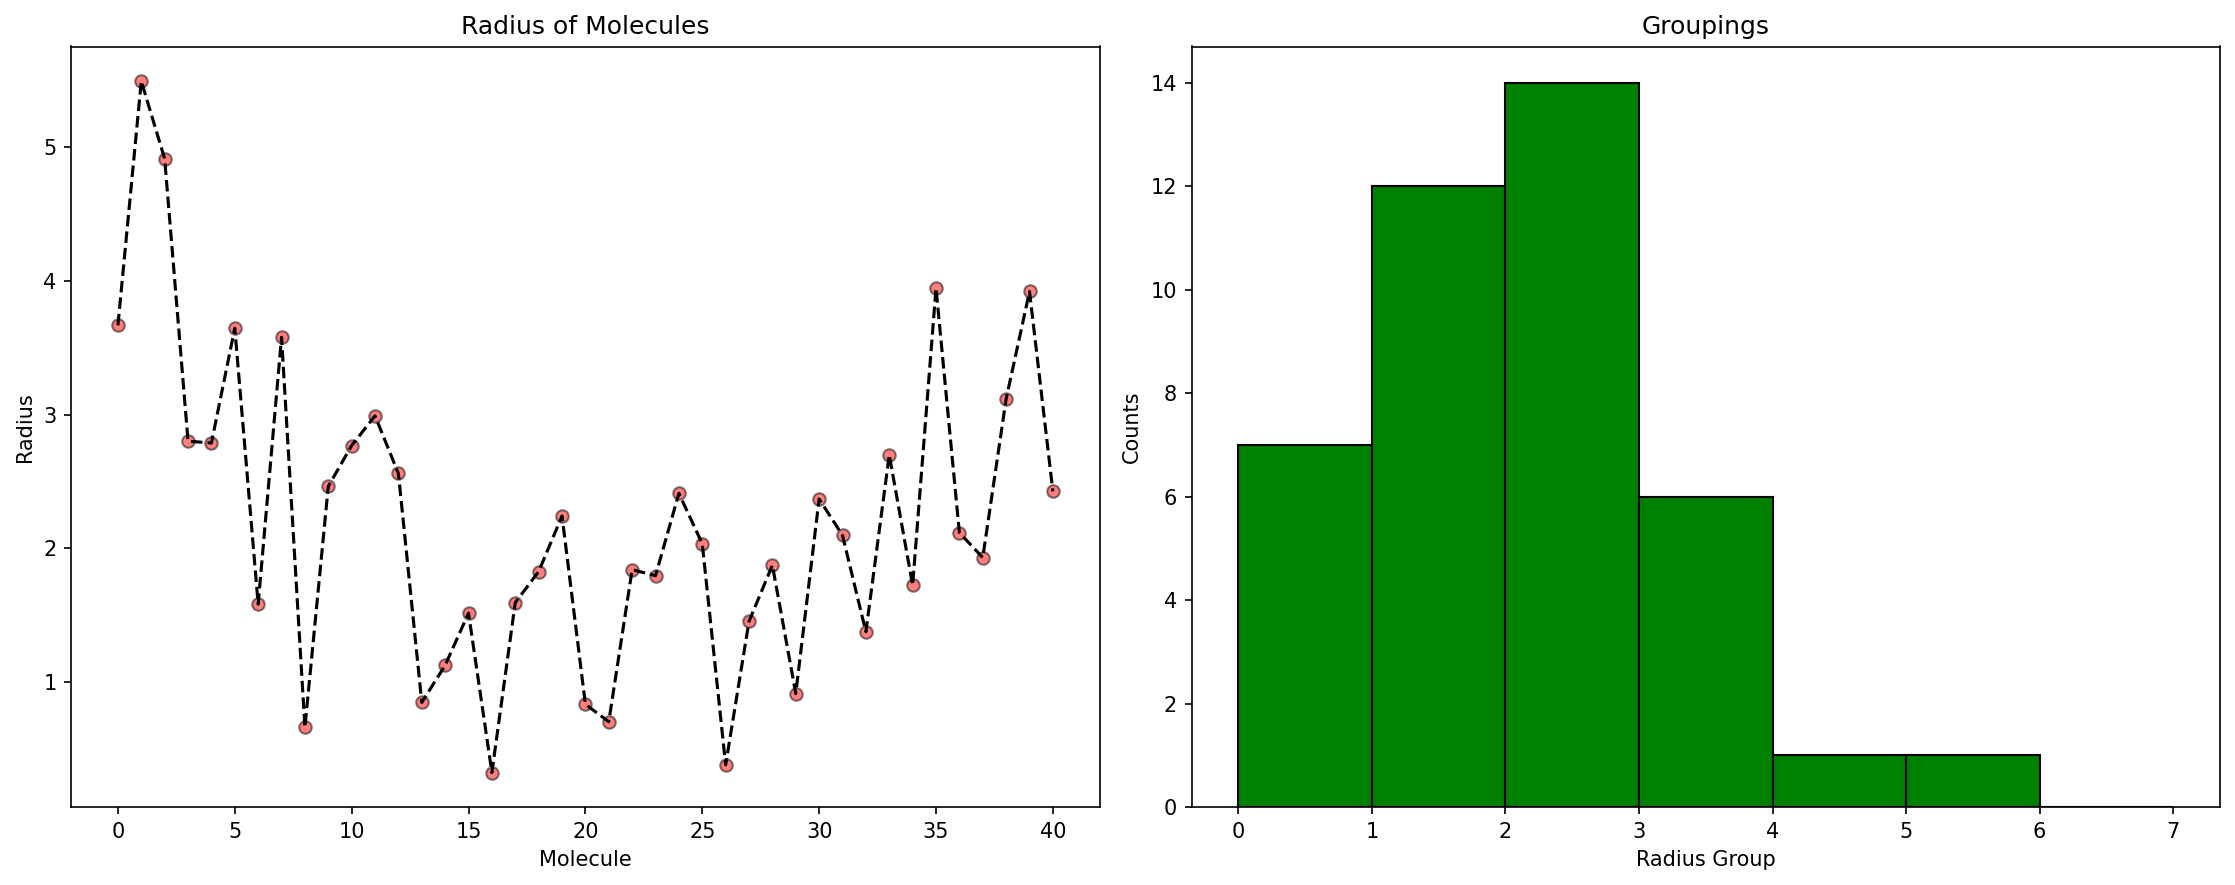

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=150)

# --- Plot ---
axs[0].plot(np.arange(tot_mol), radius, '--', color='k')
axs[0].scatter(np.arange(tot_mol), radius, edgecolors='k', color='r', alpha=0.5)
axs[0].set_xlabel("Molecule")
axs[0].set_ylabel("Radius")
axs[0].set_title("Radius of Molecules")

# --- Distribution ---
bins_ar = np.arange(0,8) #0-7, steps of ones
counts, bin_edges, patches = axs[1].hist(radius, bins = bins_ar, color='green', edgecolor='black')
axs[1].set_xlabel("Radius Group")
axs[1].set_ylabel("Counts")
axs[1].set_title("Groupings")

plt.tight_layout()
plt.show()

Lets get the group $r \in [3,4]$. What Im gonna do is get the angle function of this molecules as:

$$
\varphi(z) = \arctan \left({\frac{y(z)-y_c(z)}{x(z) - x_c(z)}} \right)
$$


In [23]:
mol_range = np.where((radius >= bin_edges[3]) & (radius < bin_edges[4]))[0]
mol_n = len(mol_range)

phi_m = [] # slope storage
phi_b = [] # intercept storage

# Get the angle function of each molecule and then get the lines phi(z)
for mol in mol_range:
    st_v, ed_v = e2e_triple_mean_vec(mol, mask) # End to End
    m_mol, b_mol = line_par(st_v, ed_v) # Functions
    # phi_mol = lambda z: np.atan2((y_mol(z) - y_cf(z)), (x_mol(z) - x_cf(z))) # function of mol
    phi_m.append(m_mol)
    phi_b.append(b_mol)

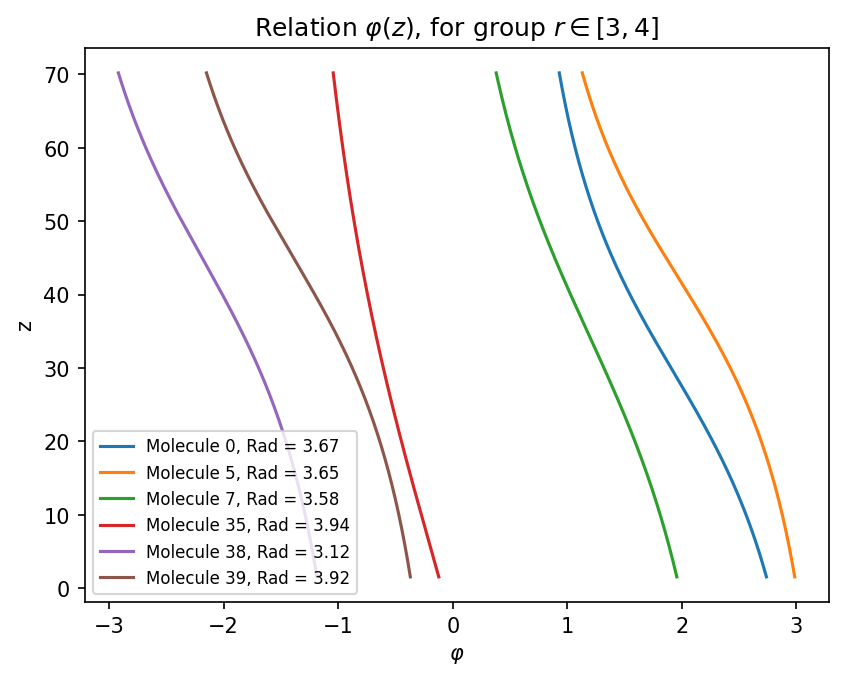

In [24]:
plt.figure(dpi=150)
z_eval = np.linspace(z_mn, z_mx, 1000)

for i, mol in enumerate(mol_range):
    mx, my = phi_m[i]
    bx, by = phi_b[i]
    fun_phi = lambda z: np.atan2((my*z + by - y_cf(z)), (mx*z + bx - x_cf(z)))
    plt.plot(fun_phi(z_eval), z_eval, label=f"Molecule {mol}, Rad = {radius[mol]:.2f}")

plt.xlabel(r"$\varphi$")
plt.ylabel("z")
plt.title("Relation "+r"$\varphi(z)$" + ", for group " + r"$r \in [3,4]$")
plt.legend(fontsize = 8)
plt.show()

Now lets see the group $r \in [0, 1]$

In [25]:
# Just when we have a mapping as 0, n where n is an integer and steps are of 1
up_lim = 1
low_lim = 0

mol_range = np.where((radius >= bin_edges[low_lim]) & (radius < bin_edges[up_lim]))[0]
mol_n = len(mol_range)

phi_m = [] # slope storage
phi_b = [] # intercept storage

# Get the angle function of each molecule and then get the lines phi(z)
for mol in mol_range:
    st_v, ed_v = e2e_triple_mean_vec(mol, mask) # End to End
    m_mol, b_mol = line_par(st_v, ed_v) # Functions
    phi_m.append(m_mol)
    phi_b.append(b_mol)

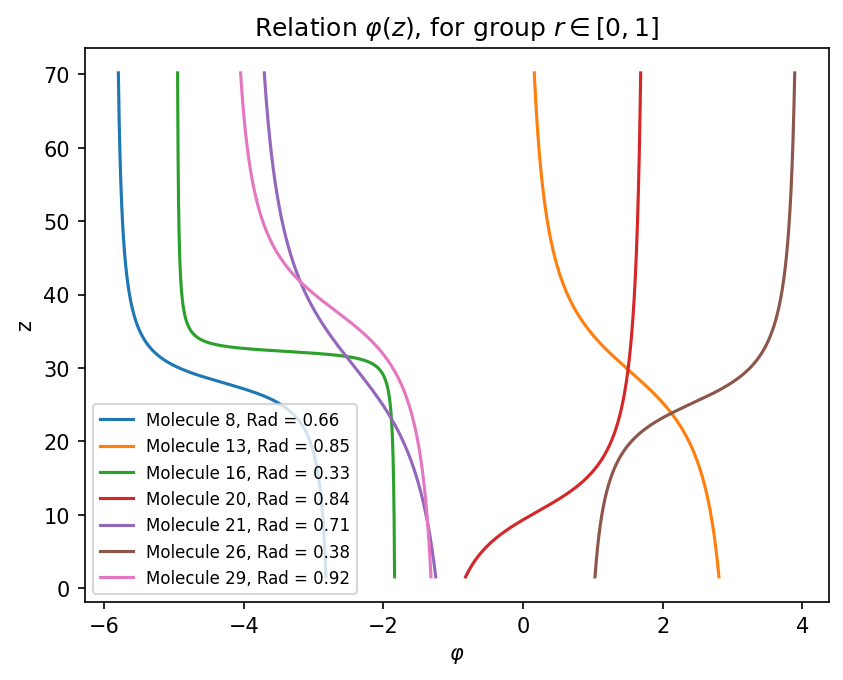

In [ ]:
plt.figure(dpi=150)
z_eval = np.linspace(z_mn, z_mx, 1000)

for i, mol in enumerate(mol_range):
    mx, my = phi_m[i]
    bx, by = phi_b[i]
    fun_phi = lambda z: np.atan2((my*z + by - y_cf(z)), (mx*z + bx - x_cf(z)))
    # Unwrapping for dealing with jumps
    phi_p = fun_phi(z_eval)
    phi_uw = np.unwrap(phi_p[np.argsort(z_eval)], discont=np.pi)
    plt.plot(phi_uw, z_eval, label=f"Molecule {mol}, Rad = {radius[mol]:.2f}")

plt.xlabel(r"$\varphi$")
plt.ylabel("z")
plt.title("Relation "+r"$\varphi(z)$" + ", for group " + rf"$r \in [{low_lim},{up_lim}]$")
plt.legend(fontsize = 8)
plt.show()